**Ситуация.**

Многие покупатели всего один раз делают заказ в онлайн магазине. Такое событие происходит по множеству причин и онлайн дилеры пытаются противодействовать этому, используя соответствующие методы оценки лояльности клиентов. К примеру, проверенным методом является раздача ваучеров через некоторое время после покупки, чтобы стимулировать покупателя сделать следующий заказ. Однако отправлять ваучеры всем покупателям не самое хорошее решение с экономической точки зрения, поскольку клиенты могут совершить покупку и без него.

**Задача.**

Используя имеющиеся характеристики исходного заказа клиента, такие как объем заказа по каждому виду товара, доступность товара, вес поставки, необходимо принять решение, оправлять ли ваучер стоимостью € 10.00. Надо давать ваучер тем клиентам, которые сами не решились бы сделать следующий заказ. Как показывает практика, можно считать, что ваучер влечет покупку со средней стоимостью € 40.00 в 10 случаях из 100 среди тех, когда покупки не было. Если отправить ваучер клиенту, который все равно сделает следующий заказ, то дилер теряет € 10.00. Таким образом, стоит задача максимизации выручки путем отправки ваучеров нужным клиентам. Используя данные из файла ```train.txt```, необходимо построить модель, которая определяла бы клиентов, описанных в файле ```class.txt```, которые должны получить ваучер.

**Оценка результатов.**

Если послать ваучер клиенту, а он в любом случае сделает заказ, то выручка уменьшится на € 10.00. Если послать ваучер клиенту, который ничего бы не заказал, то выручка увеличивается, в среднем, на € 3.00.

**Найти**

Разметить выборку raw_unlabeled на (0, 1), максимизировав предложенный функционал качества.

**Признаки**

* salutation - ответственное лицо.
* title - доступность товара.
* domain - домен.
* newsletter - новостная подписка.
* model - неизвестно.
* paymenttype - вид платежа.
* deliverytype - вид доставки.
* voucher - погашен ли ваучер на данном заказе.
* invoicepostcode - почтовый индекс по накладной.
* case - ценность товаров.
* numberitems - общее количество товаров.
* gift - подарок.
* entry - откуда клиент нашел магазин.
* points - погашены ли очки.
* shippingcosts - включены ли расходы на доставку.
* weight - вес товаров.
* remi - число отправленных товаров.
* cancel - число отмененных товаров.
* w0 - число заказанных книг с переплетами.
* w1 - число заказанных книг в мягкой обложке.
* w2 - число заказанных школьных учебников.
* w3 -  Число заказанных электронных книг.
* w4 -  Число заказанных аудио-книг.
* w5 -  Число заказанных аудио-книг (download).
* w6 -  Число заказанных фильмов.
* w7 -  Число заказанных музыкальных товаров.
* w8 -  Число заказанной товаров электроники.
* w9  - число заказанных импортных товаров.
* w10 - число прочих заказанных товаров.
* deliverydatepromised@month - месяц обещанной даты доставки.
* deliverydatepromised@dayofweek - день недели обещанной даты доставки.
* datecreated@month - месяц создания аккаунта.
* datecreated@dayofweek - день недели создания аккаунта.
* deliverydatereal@month - месяц реальной даты доставки.
* deliverydatereal@dayofweek - день недели реальной даты доставки.
* date@month - месяц, в который был сделан исходный заказ.
* date@dayofweek - день недели, в который был сделан исходный заказ.
* deliverydelta - разница между обещанной датой доставки и реальной датой доставки.
* advertisingdatacode - код рекламных данных.
* delivpostcode - почтовый индекс адреса доставки.
* **target90 - целевая переменная в train**

----

Комментарий: Результат предсказаний лучшей модели следует предоставить в csv-файле с колонками "customernumber" и "pred". В процессе решения задачи следует уделить вниманию обзору данных и сравнению различных алгоритмов.

In [1]:
import pandas as pd

from sklearn.preprocessing import OneHotEncoder


raw_data = pd.read_csv('./train.csv', delimiter=';', low_memory=False)
raw_unlabeled = pd.read_csv('./test.csv', delimiter=';', low_memory=False)

In [2]:
raw_unlabeled['pred'] = 0
raw_unlabeled[['customernumber', 'pred']].to_csv('preds.csv', index=False)

In [3]:
print(raw_data.columns)

Index(['customernumber', 'date', 'salutation', 'title', 'domain',
       'datecreated', 'newsletter', 'model', 'paymenttype', 'deliverytype',
       'invoicepostcode', 'delivpostcode', 'voucher', 'advertisingdatacode',
       'case', 'numberitems', 'gift', 'entry', 'points', 'shippingcosts',
       'deliverydatepromised', 'deliverydatereal', 'weight', 'remi', 'cancel',
       'used', 'w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8', 'w9',
       'w10', 'target90'],
      dtype='object')


Отсутствует потенциально полезный признак deliverydelta, а так же есть неизвестные признаки model и used.

Для начала введем предложенный признак deliverydelta (его нет в исходных данных, однако есть даты ожидаемой и реальной даты доставки). Оказывается, что иногда дата записанна некорректно, ('0000-00-00'). В таких случаях значение deliverydelta поставим 1000, как число, которого явно не может быть в реальной статистике доставки

In [4]:
x0 = raw_data.copy()
y = raw_data.target90

In [5]:
from datetime import datetime
date_format = "%Y-%m-%d"

def delta_days(x):
    x['deliverydelta'] = 0

    for i in range(len(x)):
        a = x.iloc[i, x.columns.get_loc('deliverydatepromised')]
        b = x.iloc[i, x.columns.get_loc('deliverydatereal')]
        if (a == '0000-00-00')or (b == '0000-00-00'):
            x.iloc[i, x.columns.get_loc('deliverydelta')] = 1000
        else:
            a_t = datetime.strptime(a, date_format)
            b_t = datetime.strptime(b, date_format)
            delta = b_t - a_t
            x.iloc[i, x.columns.get_loc('deliverydelta')] = delta.days
            
    return(x)

In [6]:
x0 = delta_days(x0)

Уберем остальные признаки с датами

In [7]:
x1 = x0.drop(['deliverydatepromised', 'deliverydatereal', 'date', 'datecreated'], axis = 1)

In [8]:
cat_check = ['paymenttype', 'salutation', 'title', 'newsletter', 'entry' ,'model', 'used',
             'delivpostcode', 'advertisingdatacode', 'invoicepostcode', 'domain','deliverytype']

for col in cat_check:
    print (col, ': ', raw_data[col].unique())

paymenttype :  [1 0 3 2]
salutation :  [1 0 2]
title :  [0 1]
newsletter :  [0 1]
entry :  [0 1]
model :  [1 3 2]
used :  [ 0  3  1  2 13 12  5  4  9  8  6  7 10 11]
delivpostcode :  [nan '99' '15' '70' '50' '14' '53' '22' '41' '88' '81' '46' '27' '44' '04'
 '52' '72' '17' '21' '35' '60' '97' '82' '28' '30' '10' '91' '90' '86'
 '40' '51' '45' '57' '49' '07' '92' '85' '71' '47' '96' '55' '64' '23'
 '34' '37' '76' '13' '48' '24' '80' '16' '63' '59' '06' '12' '89' '65'
 '69' '08' '67' '01' '42' '0' '32' '94' '98' '93' '73' '33' '31' '61' '78'
 '58' '25' '36' '74' '54' '83' '02' '56' '18' '68' '75' '19' '03' '29'
 '87' '79' '11' '95' '20' '39' '26' '38' '84' '66' '09' 'EN' '00' 'Nl']
advertisingdatacode :  [nan 'BQ' 'AP' 'CA' 'BD' 'AB' 'BC' 'BI' 'BT' 'AQ' 'BR' 'AH' 'AX' 'BF' 'AE'
 'AR' 'BL' 'BO' 'BB' 'AT' 'BZ' 'BM' 'BA' 'BY' 'AZ' 'AK' 'AW' 'AO' 'AL'
 'AU' 'AV' 'AI' 'AM' 'BS' 'BV' 'BG' 'AC' 'AD' 'BE' 'BX' 'AF' 'BK']
invoicepostcode :  [34 51 25 95 78 77 86 97 58 50 40 99 88 17 68 15 63 89 4

Признаки 'used', 'delivpostcode', 'advertisingdatacode', 'invoicepostcode', 'domain' имеют большое количество разнообразных значений, их не стоит преобразовывать через OneHotEncoder, но им можно вместо дискретных значений присвоить вероятность равенства целевой переменной единице при каждом из значений.

Признаки  'title', 'newsletter', 'entry' и 'deliverytype' имеют всего по два значения, их можно оставить без изменений.

Остаются 'paymenttype', 'salutation' и 'model', которые можно прогнать через OneHotEncoder.

Перекодируем некоторые признаки.

In [9]:
def apply_ohe(cat, x):
    ohe = OneHotEncoder(sparse=False) 
    for col in cat.columns:
        new_ohe_features = ohe.fit_transform(cat[col].values.reshape(-1, 1))
        tmp = pd.DataFrame(new_ohe_features, columns=[col + str(i) for i in range(new_ohe_features.shape[1])])
        x = x.drop([col], axis=1)
        x = pd.concat([x, tmp], axis = 1)
    return(x)

In [10]:
cat = x1.iloc[:, x1.columns.get_indexer(['paymenttype', 'salutation', 'model'])]

x1 = apply_ohe(cat, x1)
    

In [11]:
#у признака delivpostcode всего 4% не NaN данных, а у advertisingdatacode - 20%. 
deliv = x1.delivpostcode
print('delivpostcode: ', round((len(deliv.dropna())/len(x1))*100, 1), '%')
adv = x1.advertisingdatacode
print('advertisingdatacode: ', round((len(adv.dropna())/len(x1))*100, 1), '%')

delivpostcode:  4.1 %
advertisingdatacode:  19.8 %


Уберем из выборки delivpostcode и advertisingdatacode.
Для 'used', 'invoicepostcode' и 'domain' заменим значения на вероятности, однако, в кросс-валидации это нужно делать на каждой итерации заново, так что сейчас просто уберем эти признаки, а при настройке модели воспользуемся функцией cat_feat_to_probs()

In [12]:
x2 = x1.drop(['delivpostcode', 'advertisingdatacode', 'used', 'invoicepostcode', 'domain'], axis = 1)
cat = raw_data.iloc[:, raw_data.columns.get_indexer(['used', 'invoicepostcode', 'domain'])].copy()


In [13]:
def cat_feat_to_probs(cats_train, cats_test, y):    

    for col in cats_train.columns:
        
        for feat in cats_train[col].unique():
            t = y.where(cats_train[col]==feat).sum()
            l = len(cats_train[col].where(cats_train[col]==feat).dropna())
            #print(t, l)
            p = t/l
            for i in range(len(cats_train)):
                if (cats_train.iloc[i, cats_train.columns.get_loc(col)]==feat):
                    cats_train.iloc[i, cats_train.columns.get_loc(col)]=p
            for i in range(len(cats_test)):
                if (cats_test.iloc[i, cats_test.columns.get_loc(col)]==feat):
                    cats_test.iloc[i, cats_test.columns.get_loc(col)]=p
                    

    return (np.array(cats_train), np.array(cats_test))

Или тоже заменим их методом OneHotEncoder.

In [14]:
Apply_ohe = False

if Apply_ohe:
    ohe = OneHotEncoder(sparse=False) 
    for col in cat.columns:
        new_ohe_features = ohe.fit_transform(cat[col].values.reshape(-1, 1))
        tmp = pd.DataFrame(new_ohe_features, columns=[col + str(i) for i in range(new_ohe_features.shape[1])])
        x2 = pd. concat([x2, tmp], axis = 1)

In [17]:
print(len(x2.customernumber.unique()))
print(len(x2))

21619
21619


Так как все покупатели уникальны, выкинем столбец customernumber. И целевую переменную тоже выкинем.

In [18]:
x3 = x2.drop(['customernumber', 'target90'], axis = 1)

Посчитаем дни недели и их вероятности (да, их тоже надо было бы засунуть внутрь кросс-валидации, но давайте как минимум проверим, есть ли между ними разница)

In [21]:
wd = raw_data.iloc[:, raw_data.columns.get_indexer(['datecreated', 'deliverydatepromised', 'deliverydatereal'])].copy()
day = 0

for col in wd.columns:

    for i in range(len(raw_data)):
        a = wd.iloc[i, wd.columns.get_loc(col)]
        if (a == '0000-00-00'):
             wd.iloc[i, wd.columns.get_loc(col)] = 7
        else:
            day = datetime.strptime(a, date_format).weekday()
            wd.iloc[i, wd.columns.get_loc(col)] = day
            
#заменять с помощью OneHotEncoder - это 20 с лишним признаков, поэтому попробуем посчитать вероятности, 
#посомтрим, будет ли разница между днями недели

for col in wd.columns:

    for feat in wd[col].unique():
        t = y.where(wd[col]==feat).sum()
        l = len(wd[col].where(wd[col]==feat).dropna())
        #print(t, l)
        p = t/l
        for i in range(len(raw_data)):
            if (wd.iloc[i, wd.columns.get_loc(col)]==feat):
                wd.iloc[i, wd.columns.get_loc(col)]=p

In [22]:
print(wd['datecreated'].unique())
print(wd['deliverydatepromised'].unique())
print(wd['deliverydatereal'].unique())

[0.17406241 0.19305127 0.19011281 0.1898971  0.18475336 0.18041431
 0.18719212]
[0.18737295 0.18284024 0.18642013 0.18239839 0.18694444]
[0.19164265 0.18038654 0.19504222 0.17706294 0.18380376 0.18836565
 0.18627451 0.14983713]


По всей видимости, зачастую мы вообще не знаем итоговую дату доставки, а все остальные дни недели распределены примерно равнозначно. Не будем пользоваться этими признаками.

In [23]:
#нам достались несимметричные данные
print('target90=1 в '+str(round((y.sum()/len(y))*100, 1))+'% случаев')

target90=1 в 18.6% случаев


In [24]:
#это будут данные без дней недели, к тому же не симметризованные по количеству 0 и 1 в target90
#можно остановиться на этом.
x_raw = x3.copy()
y_raw = raw_data.target90

Самый глупый способ симметризации - случайным образом обрезать "нули" по количеству "единиц". Правда, данных этом остается мало. Однако, это не должно так сильно обрезать качество, в любом случае.

In [25]:
def symm(x, y):

    #объединим X и y для синхронного перемешивания.
    x = pd.concat([x, y], axis = 1)

    #разделим x на нули и единицы
    x_0 = x.where(y==0).dropna()
    x_1 = x.where(y==1).dropna()

    #сделаем обрезанную подвыборку и перемешаем ее с помощью sample
    x = pd.concat([x_1, x_0.sample(n = len(x_1))], axis = 0).sample(frac = 1)

    #снова выделим X и y 
    y = x.target90
    x = x.drop('target90', axis = 1)
    
    return (x, y)

Подготовка данных завершена. У нас есть таблица признаков X и столбец ответов y. 
Можно приступать к обучению моделей.

In [26]:
import numpy as np
import statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold, cross_val_score, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

In [27]:
#Выберем данные.
x, y = x_raw, y_raw 
#но вообще, надо признать, тестовые данные тоже будут примерно такими же - ассиметричными. 
#И метрика, по которой мы будем отбирать итоговое значение, тоже должна будет работать на несимметричным данных, 
#так что пусть будет так.

#x, y = symm(x3, y)


Делать цикл с классификаторами можно было бы, но неудобно из-за подбора параметров. Вообще можно подставить любой из списка, они все дают примерно один и тот же результат. Но можно для примера разоюрать качество какой-нибудь пары или тройки.

In [28]:
cv = KFold(n_splits=5, shuffle=True)
estimator = GradientBoostingClassifier()
#grid = {'C': np.power(10.0, np.arange(-3,3))}
grid = {'n_estimators': np.arange(7, 15)*10}

X_scaled = StandardScaler().fit_transform(x)

gs = GridSearchCV(estimator, grid, scoring='roc_auc', cv=cv, verbose=False)
gs.fit(X_scaled, y)
print(gs.best_params_['n_estimators'], 
      statistics.mean(cross_val_score(gs.best_estimator_,X_scaled, y=y, cv=cv, scoring='roc_auc')))

130 0.62736718362771


In [29]:
cv = KFold(n_splits=5, shuffle=True)
estimator = LogisticRegression()
grid = {'C': np.power(10.0, np.arange(-3,3))}
#grid = {'n_estimators': np.arange(1, 10)*10}

X_scaled = StandardScaler().fit_transform(x)

gs = GridSearchCV(estimator, grid, scoring='roc_auc', cv=cv, verbose=False)
gs.fit(X_scaled, y)
print(gs.best_params_['C'], 
      statistics.mean(cross_val_score(gs.best_estimator_,X_scaled, y=y, cv=cv, scoring='roc_auc')))

0.001 0.6099313802649659


Дальше идет многострадальная кросс-валидация с пересчитыванием вероятностных признаков - на каждой итерации считается вероятности по тренировочной части, а потом они же приписываются и тестовой части. 
Ожидаемо, считается оно страшно долго, так что есть возможность быстренько прогнать кросс-валидацию без этих признаков, или с ними, но пропущенных через OneHotEncoder (см.выше)
Тем более, что разница пока была невелика.

In [ ]:
accs = []
kf = KFold(n_splits=5, shuffle=False)


if not(Apply_ohe):
    for train, test in kf.split(X_scaled):


        X_train_part, X_test_part = X_scaled[[train]], X_scaled[[test]]
        y_train_part, y_test_part = y[train], y[test]

        cat_train, cat_test = cat_feat_to_probs(cat.iloc[train, :].copy(), cat.iloc[test, :].copy(), y_train_part)
        scaler = StandardScaler()

        cat_train = scaler.fit_transform(cat_train)
        cat_test = scaler.transform(cat_test)

        X_train_part = np.concatenate([X_train_part, cat_train], axis = 1)
        X_test_part = np.concatenate([X_test_part, cat_test], axis = 1)

        clf = LogisticRegression(C = 0.1)

        clf.fit(X_train_part, y_train_part)

    #    predictions = clf.predict(X_test_part)  
        pred_probs = clf.predict_proba(X_test_part)
        acc = roc_auc_score(y_test_part, pred_probs[:, 1])
        accs.append(acc)
        print(acc)

    print(np.mean(accs))
else: print('эти признаки уже есть в виде Ohe')

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y.values, test_size=0.2, random_state=0)

y_probas = []
names = ['RandomForestClassifier', 'LogisticRegression', 'GradientBoostingClassifier']

for clfs in [RandomForestClassifier(n_estimators=80), LogisticRegression(C=1), GradientBoostingClassifier(n_estimators = 130)]:
    clfs.fit(X_train, y_train)
    y_probas.append(clfs.predict_proba(X_test))
    

In [32]:
def buisnes_metric(y_proba, y, thresholds):
    incomes = []
    for threshold in thresholds:
        y_pred = np.copy(y_proba)
        y_pred[y_proba<=threshold] = 1
        y_pred[y_proba>threshold] = 0
        
        income = 0
        for i in range (len(y_pred)):
            
            if y_pred[i] == y[i] == 0:
                income += 0
            elif ((y_pred[i] == 1) and (y[i] == 0)): 
                income += 3
            elif ((y_pred[i] == 0) and (y[i] == 1)):
                income += 0
            else:
                income -= 10 
        incomes.append(income)
    return(incomes)
        

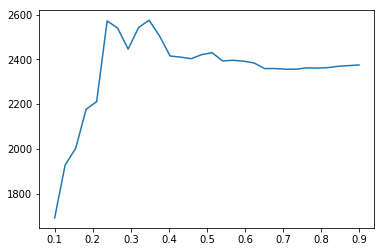

RandomForestClassifier
оптимальное пороговое значение:  0.35
выручка при оптимальном пороговом значении:  2575


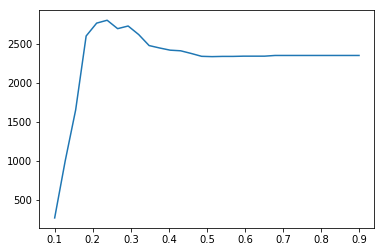

LogisticRegression
оптимальное пороговое значение:  0.24
выручка при оптимальном пороговом значении:  2803


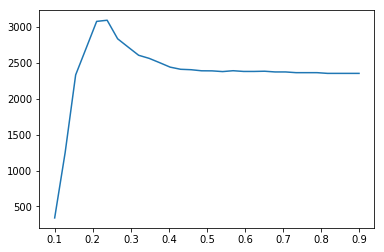

GradientBoostingClassifier
оптимальное пороговое значение:  0.24
выручка при оптимальном пороговом значении:  3090


In [33]:
thresholds = np.linspace(0.1, 0.9, 30)
i=0 
for y_proba in y_probas:
    results = buisnes_metric(y_proba[:, 1], y_test, thresholds)

    plt.plot(thresholds, results)
    plt.show()
    
    
    print(names[i])

    i+=1
    print('оптимальное пороговое значение: ', round(thresholds[results.index(max(results))], 2))
    print('выручка при оптимальном пороговом значении: ', max(results))

Градиентный бустинг дает побольше всех остальных, так-то

In [34]:
x_test = raw_unlabeled.drop(['pred'], axis=1)
x_test = delta_days(x_test)
x_test = x_test.drop(['deliverydatepromised', 'deliverydatereal', 'date', 'datecreated'], axis = 1)   



In [35]:
Apply_ohe_to_all_cat = False

if Apply_ohe_to_all_cat:    
    cat_test = x_test.iloc[:, x_test.columns.get_indexer(['paymenttype', 'salutation', 'model', 
                                                      'used', 'invoicepostcode', 'domain'])]
else:    
    cat_test = x_test.iloc[:, x_test.columns.get_indexer(['paymenttype', 'salutation', 'model'])]

x_test = apply_ohe(cat_test, x_test)
    
x_test = x_test.drop(['delivpostcode', 'advertisingdatacode', 'used', 'invoicepostcode', 
                      'domain', 'customernumber'], axis = 1)       


Можно пересчитать эти признаки в вероятности

In [36]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(x)
x_test = scaler.transform(x_test)

In [37]:
Apply_prob_feat = False

if Apply_prob_feat:    
    cat_train = raw_data.iloc[:, raw_data.columns.get_indexer(['used', 'invoicepostcode', 'domain'])]
    cat_test = raw_unlabeled.iloc[:, raw_unlabeled.columns.get_indexer(['used', 'invoicepostcode', 'domain'])]

    cat_train, cat_test = cat_feat_to_probs(cat_train, cat_test)

    cat_train = StandardScaler().fit_transform(cat_train)
    cat_test = StandardScaler().fit_transform(cat_test)


    X_scaled = np.concatenate([X_scaled, cat_train], axis = 1)
    x_test = np.concatenate([x_test, cat_test], axis = 1)


In [38]:
clf = GradientBoostingClassifier()
clf.fit(X_scaled, y)
y_test_pred = clf.predict_proba(x_test)[:, 1]
threshold = 0.24


In [39]:
print(y_test_pred)

[0.17621403 0.32725071 0.14256435 ... 0.26204065 0.16840356 0.18905718]


In [40]:
y_result = np.copy(y_test_pred)       
y_result[y_test_pred<=threshold] = 1
y_result[y_test_pred>threshold] = 0


In [65]:
result = raw_unlabeled.iloc[:, raw_unlabeled.columns.get_indexer(['customernumber'])].copy()
result['pred'] = y_result


In [66]:
result.to_csv('test_labels.csv', index = False)

In [67]:
print(pd.read_csv('test_labels.csv'))

       customernumber  pred
0               46743   1.0
1               24108   0.0
2               31500   1.0
3               16864   1.0
4               63484   1.0
5               56763   1.0
6               17750   0.0
7               58248   1.0
8               33948   0.0
9                5445   1.0
10              33373   1.0
11              11111   1.0
12              48783   1.0
13              33060   1.0
14              12832   1.0
15              10785   1.0
16              63629   1.0
17              42345   1.0
18              57790   0.0
19               1410   1.0
20              10414   1.0
21              12848   1.0
22              40935   1.0
23              11516   1.0
24              34233   1.0
25              23095   0.0
26              46526   1.0
27              43325   1.0
28              23368   0.0
29              32223   1.0
...               ...   ...
10779           57950   1.0
10780           43188   0.0
10781           28804   0.0
10782           5910